In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

sns.set()

In [2]:
# ETF 가격 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('M').last()

[*********************100%***********************]  9 of 9 completed


In [3]:
# 수익률
ret = data.pct_change().dropna()

# 공분산 행렬
cov_mat = ret.cov() * 12

# 변동성
vols = ret.std() * np.sqrt(12)

In [4]:
# 고정 상관계수
corr_mat = ret.corr()

const_corr = (corr_mat.sum().sum() - len(corr_mat)) / (len(corr_mat) ** 2 - len(corr_mat))
print(const_corr)

0.617532367837867


In [5]:
# Shrinkage 방법을 적용한 공분산 행렬 계산
def covMatShrinkage(cov_mat, vols, const_corr, phi):

    # 자산 갯수
    N = cov_mat.shape[0]

    # 고정 상관계수로 상관계수 행렬 생성
    const_corr_mat = np.full((N, N), const_corr)
    np.fill_diagonal(const_corr_mat, 1.0)

    # 자산별 변동성
    vols_mat = np.diag(vols)

    # 상관계수 행렬을 공분산 행렬로 변환
    const_corr_mat = vols_mat.T @ const_corr_mat @ vols_mat

    # 두 공분산 행렬을 블렌딩
    cov_mat_hat = (1 - phi) * cov_mat + phi * const_corr_mat

    # 업데이트된 공분산 행렬 반환
    return cov_mat_hat

In [6]:
# 가중치
phi = 0.7

# Shrinkage 방법을 적용한 새로운 공분산 행렬
cov_mat_hat = covMatShrinkage(cov_mat, vols, const_corr, phi)

<Axes: >

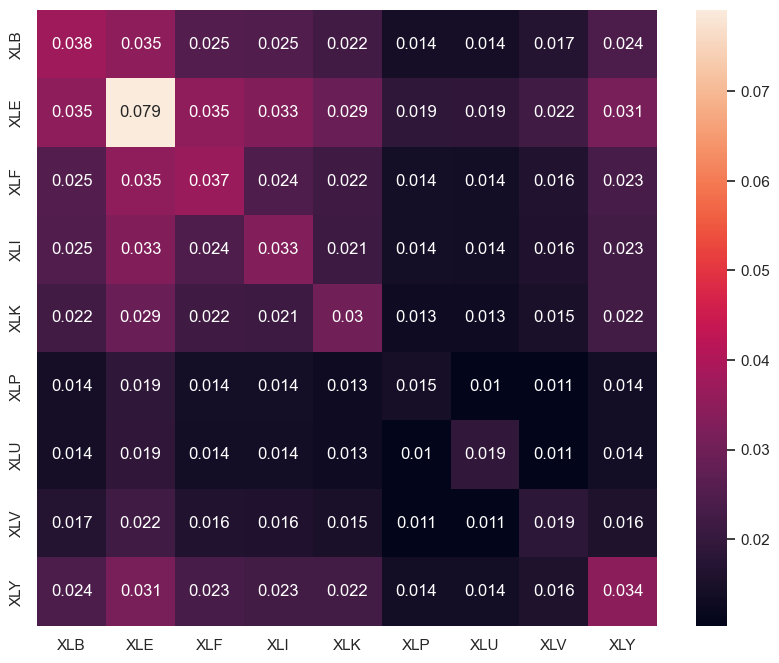

In [7]:
# 업데이트된 공분산 행렬 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(cov_mat_hat, annot=True)

<Axes: >

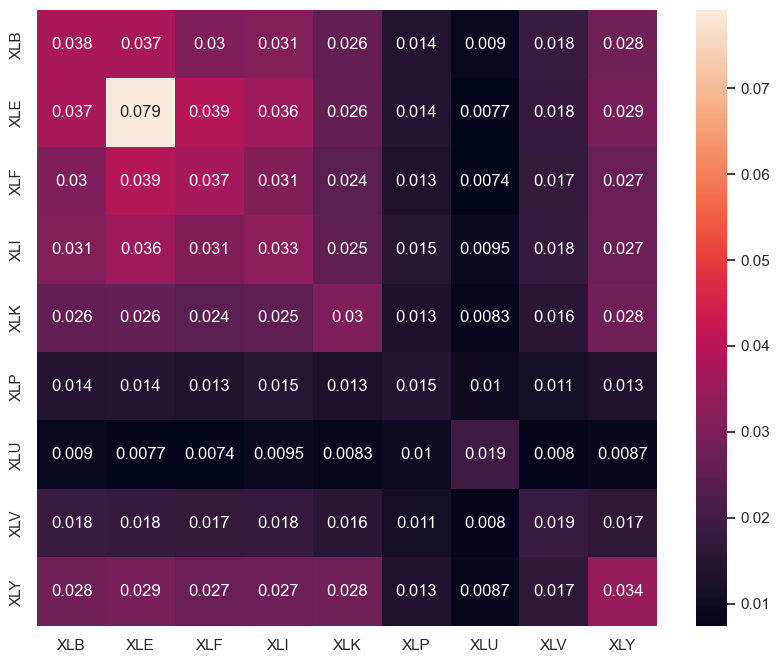

In [8]:
# 기존 공분산 행렬 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(cov_mat, annot=True)